# Quarter-Mile Race from Standing Start: RWD vs AWD



This notebook simulates a **standing-start quarter-mile race** (402.336 m) between two cars with different acceleration characteristics.



## What you can customize per car

- Weight (`mass`)

- Drivetrain (`RWD` or `AWD`)

- Transmission (`manual`, `auto`, `dct`)

- Tire width (`tire_width_mm`)

- Tire compound (`all_season`, `summer`, `track`, `drag_radial`)

- Power and aero (`power_kw`, `CdA`)



Tire width and compound are used to estimate traction (effective `mu`), and transmission affects launch and power efficiency.



The notebook includes:

- Acceleration functions for both cars

- Speed vs Time plot

- Distance vs Time plot

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81                     # m/s^2
rho_air = 1.225             # kg/m^3
quarter_mile_m = 402.336    # m

# Time integration step
dt = 0.01

In [54]:
# Single place to customize both cars

car_specs = {

    "RWD Car": {

        "mass": 1550,

        "power_kw": 500,

        "drivetrain": "RWD",      # RWD or AWD

        "transmission": "manual", # manual, auto, dct

        "tire_width_mm": 300,

        "tire_compound": "summer", # all_season, summer, track, drag_radial

        "CdA": 0.66,

        "base_mu": 1.05,

    },

    "AWD Car": {

        "mass": 2300,

        "power_kw": 700,

        "drivetrain": "AWD",

        "transmission": "auto",

        "tire_width_mm": 300,

        "tire_compound": "summer",

        "CdA": 0.68,

        "base_mu": 1.05,

    },

}

In [55]:
# --- Physics/model functions ---



TRANSMISSION_PROFILES = {

    "manual": {"power_efficiency": 0.94, "launch_factor": 0.98},

    "auto": {"power_efficiency": 0.96, "launch_factor": 1.00},

    "dct": {"power_efficiency": 0.98, "launch_factor": 1.02},

}



DRIVETRAIN_BASE = {

    "RWD": {"drive_factor": 0.93},

    "AWD": {"drive_factor": 1.00},

}



TIRE_COMPOUND_GRIP = {

    "all_season": 0.95,

    "summer": 1.00,

    "track": 1.08,

    "drag_radial": 1.15,

}



def tire_grip_multiplier(tire_width_mm, tire_compound="summer"):

    width_factor = (tire_width_mm / 245.0) ** 0.30

    width_factor = float(np.clip(width_factor, 0.90, 1.15))

    compound_factor = TIRE_COMPOUND_GRIP.get(tire_compound, 1.00)

    return width_factor * compound_factor



def make_car(name, mass, power_kw, drivetrain, transmission, tire_width_mm, tire_compound, CdA, base_mu=1.05):

    drivetrain = drivetrain.upper()

    transmission = transmission.lower()



    drive_factor = DRIVETRAIN_BASE[drivetrain]["drive_factor"]

    trans = TRANSMISSION_PROFILES[transmission]

    tire_factor = tire_grip_multiplier(tire_width_mm, tire_compound)



    return {

        "name": name,

        "mass": float(mass),

        "power_kw": float(power_kw),

        "CdA": float(CdA),

        "drivetrain": drivetrain,

        "transmission": transmission,

        "tire_width_mm": float(tire_width_mm),

        "tire_compound": tire_compound,

        "base_mu": float(base_mu),

        "mu": float(base_mu) * tire_factor,

        "drive_factor": drive_factor * trans["launch_factor"],

        "power_efficiency": trans["power_efficiency"],

    }



# Build simulation-ready cars from the single car_specs cell

cars = {

    name: make_car(name=name, **spec)

    for name, spec in car_specs.items()

}



def acceleration(v, car):

    """Net longitudinal acceleration (m/s^2) at speed v (m/s)."""

    mass = car["mass"]

    power_w = car["power_kw"] * 1000.0 * car["power_efficiency"]

    traction_limit = car["mu"] * g * car["drive_factor"]



    v_eff = max(v, 1.0)

    power_limit = power_w / (mass * v_eff)



    drag_force = 0.5 * rho_air * car["CdA"] * v**2

    drag_decel = drag_force / mass



    gross_accel = min(traction_limit, power_limit)

    net_accel = gross_accel - drag_decel

    return max(net_accel, 0.0)



def simulate_quarter_mile(car, dt=0.01, distance_target=quarter_mile_m):

    t = 0.0

    x = 0.0

    v = 0.0



    times = [t]

    distances = [x]

    speeds = [v]

    accels = [acceleration(v, car)]



    while x < distance_target:

        a = acceleration(v, car)

        v = v + a * dt

        x = x + v * dt

        t = t + dt



        times.append(t)

        distances.append(x)

        speeds.append(v)

        accels.append(a)



        if t > 60:

            break



    return {

        "time": np.array(times),

        "distance": np.array(distances),

        "speed": np.array(speeds),

        "accel": np.array(accels),

        "elapsed_time": t,

        "trap_speed": v,

    }

In [56]:
results = {name: simulate_quarter_mile(spec, dt=dt) for name, spec in cars.items()}



for name, r in results.items():

    car = cars[name]

    print(

        f"{name} | {car['drivetrain']} | {car['transmission']} | "

        f"{car['tire_width_mm']:.0f}mm {car['tire_compound']} tires | "

        f"mass={car['mass']:.0f}kg -> ET={r['elapsed_time']:.2f}s, trap={r['trap_speed']*3.6:.1f} km/h"

    )



winner = min(results.items(), key=lambda kv: kv[1]['elapsed_time'])[0]

print(f"\nWinner over quarter mile: {winner}")

RWD Car | RWD | manual | 300mm summer tires | mass=1550kg -> ET=9.91s, trap=241.9 km/h
AWD Car | AWD | auto | 300mm summer tires | mass=2300kg -> ET=9.73s, trap=243.5 km/h

Winner over quarter mile: AWD Car


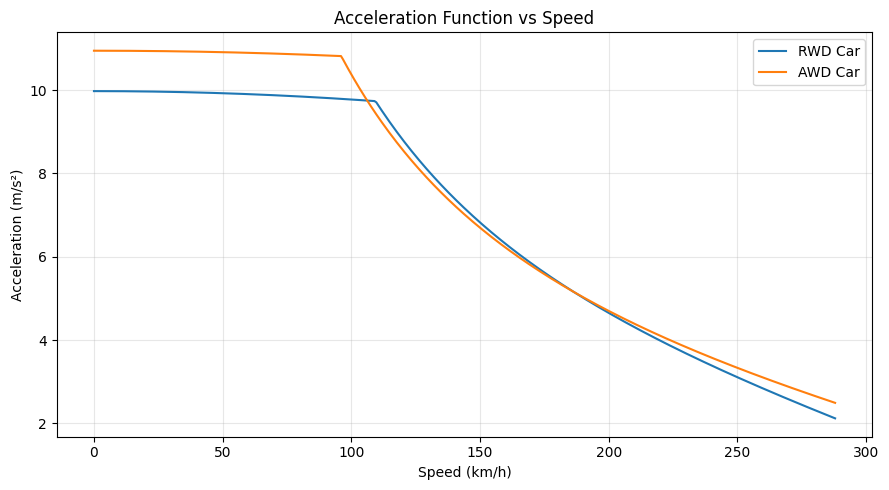

In [57]:
# 1) Acceleration functions vs speed
v_grid = np.linspace(0.0, 80.0, 400)  # m/s

plt.figure(figsize=(9, 5))
for name, car in cars.items():
    a_vals = [acceleration(v, car) for v in v_grid]
    plt.plot(v_grid * 3.6, a_vals, label=name)

plt.title("Acceleration Function vs Speed")
plt.xlabel("Speed (km/h)")
plt.ylabel("Acceleration (m/s²)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

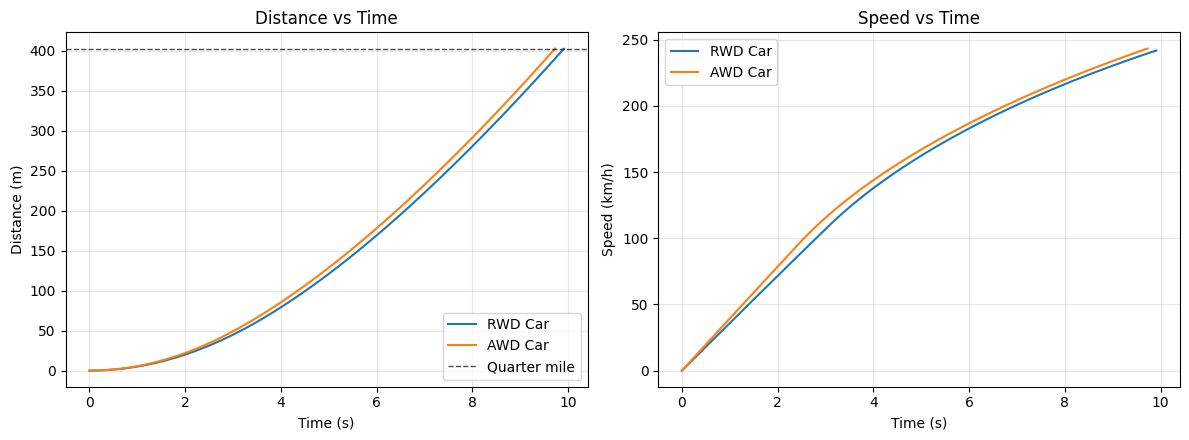

In [58]:
# 3) Race plots together: distance vs time and speed vs time

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))



for name, r in results.items():

    axes[0].plot(r['time'], r['distance'], label=name)

    axes[1].plot(r['time'], r['speed'] * 3.6, label=name)



axes[0].axhline(quarter_mile_m, linestyle='--', linewidth=1.0, color='k', alpha=0.7, label='Quarter mile')

axes[0].set_title("Distance vs Time")

axes[0].set_xlabel("Time (s)")

axes[0].set_ylabel("Distance (m)")

axes[0].grid(True, alpha=0.3)

axes[0].legend()



axes[1].set_title("Speed vs Time")

axes[1].set_xlabel("Time (s)")

axes[1].set_ylabel("Speed (km/h)")

axes[1].grid(True, alpha=0.3)

axes[1].legend()



plt.tight_layout()

plt.show()

## Notes



- Edit the `cars` dictionary in Cell 3 to set your own specs.

- The traction model is simplified and based on tire width + compound multipliers.

- The transmission model is simplified to launch and power-efficiency factors.

- This is a conceptual race model (no explicit gear-by-gear simulation).